In [ ]:
!pip uninstall -y torchvision
!pip install --no-cache-dir torchvision --index-url https://download.pytorch.org/whl/cpu

In [ ]:
!pip install --upgrade 'optree>=0.13.0'

In [51]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
# Create a temporary directory structure for PyTorch ImageFolder
import tempfile
import shutil
    

In [45]:
if torch.backends.mps.is_available():
    device = torch.device("mps")  
elif torch.cuda.is_available():
    device = torch.device("cuda")  
else:
    device = torch.device("cpu")  

print(f"Using device: {device}")


Using device: mps


In [57]:
#Define data directories
data_dir = '/Users/anastasiiaserputko/Test/Task2/Animal_dataset'

# Define transformations for training and validation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the dataset
def load_data():
    # Map folder names to class labels
    class_map = {
        'Owl': 'owl',
        'Frog': 'frog',
        'Cat': 'cat',
        'Ladybug': 'ladybug',
        'Dove': 'dove',
        'Bee': 'bee',
        'Beaver': 'beaver',
        'Flamingo': 'flamingo',
        'Elk': 'elk',
        'Fox': 'fox',
        'Squirrel': 'squirrel',
        'Goose': 'goose',
        'Bear': 'bear'
    }
    
    # Get all folders
    animal_folders = [folder for folder in os.listdir(data_dir) 
                     if os.path.isdir(os.path.join(data_dir, folder))]
    
    # Create temp dir
    temp_dir = tempfile.mkdtemp()
    train_dir = os.path.join(temp_dir, 'train')
    val_dir = os.path.join(temp_dir, 'val')
    
    # Create class directories
    for animal in class_map.values():
        os.makedirs(os.path.join(train_dir, animal), exist_ok=True)
        os.makedirs(os.path.join(val_dir, animal), exist_ok=True)
    
    # Split and copy data (80% train, 20% val)
    for folder in animal_folders:
        if folder in class_map:
            src_dir = os.path.join(data_dir, folder)
            class_name = class_map[folder]
            
            files = [f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))]
            np.random.shuffle(files)
            
            split_idx = int(len(files) * 0.8)
            train_files = files[:split_idx]
            val_files = files[split_idx:]
            
            # Copy train files
            for f in train_files:
                shutil.copy(os.path.join(src_dir, f), os.path.join(train_dir, class_name, f))
            
            # Copy val files
            for f in val_files:
                shutil.copy(os.path.join(src_dir, f), os.path.join(val_dir, class_name, f))
    
    # Load the datasets
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
    val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
    
    class_names = sorted([class_map[folder] for folder in animal_folders if folder in class_map])
    
    return train_loader, val_loader, class_names, temp_dir

# Define the model
class AnimalClassifier(nn.Module):
    def __init__(self, num_classes):
        super(AnimalClassifier, self).__init__()
        # Load pre-trained ResNet-50
        self.resnet = models.resnet50(weights='IMAGENET1K_V1')
        
        # Freeze parameters
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Replace the final fully connected layer
        num_ftrs = self.resnet.fc.in_features
        
        # Custom classifier
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.resnet(x)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15):
    best_acc = 0.0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()  

        
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.float() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc.item())
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.float() / len(val_loader.dataset)
        val_losses.append(epoch_loss)
        val_accs.append(epoch_acc.item())
        
        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {train_losses[-1]:.4f} | '
              f'Train Acc: {train_accs[-1]:.4f} | '
              f'Val Loss: {val_losses[-1]:.4f} | '
              f'Val Acc: {val_accs[-1]:.4f}')
        
        # Save the best model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), 'animal_classifier_best.pth')
    
    print(f'Best Validation Accuracy: {best_acc:.4f}')
    
    # Plot training and validation metrics
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs Epoch')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs Epoch')
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()
    
    return model

# Function to test the model and generate classification report
def evaluate_model(model, val_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Generate and print classification report
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    print(report)
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

# Function to visualize some predictions
def visualize_predictions(model, val_loader, class_names, num_images=8):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 12))
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                if images_so_far >= num_images:
                    return
                
                images_so_far += 1
                ax = plt.subplot(4, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}')
                
                # Convert image for display
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                
                plt.imshow(img)
    
    plt.tight_layout()
    plt.savefig('sample_predictions.png')
    plt.show()

# Function to unfreeze some layers for fine-tuning
def unfreeze_model_layers(model, num_layers_to_unfreeze=3):
    # Unfreeze the last num_layers_to_unfreeze layers of ResNet-50
    for name, param in model.named_parameters():
        param.requires_grad = False
    
    children = list(model.resnet.children())
    for child in children[-num_layers_to_unfreeze:]:
        for param in child.parameters():
            param.requires_grad = True
    
    # Always unfreeze the custom classifier layers
    for param in model.resnet.fc.parameters():
        param.requires_grad = True
    
    # Count trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f'Trainable parameters: {trainable_params:,} / {total_params:,} ({trainable_params/total_params:.2%})')

# Main function to run the training pipeline
def main():
    # Load data
    train_loader, val_loader, class_names, temp_dir = load_data()
    print(f"Classes: {class_names}")
    print(f"Number of classes: {len(class_names)}")
    
    # Create model
    model = AnimalClassifier(num_classes=len(class_names))
    model = model.to(device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model (first round - only training the custom layers)
    print("Phase 1: Training only the custom classifier layers...")
    model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=7)
    
    # Fine-tuning - unfreeze some layers
    print("\nPhase 2: Fine-tuning - unfreezing some ResNet layers...")
    unfreeze_model_layers(model, num_layers_to_unfreeze=5)
    
    # Update optimizer with lower learning rate for fine-tuning
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
    
    # Continue training
    model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=7)
    
    # Evaluate the model
    print("\nEvaluating the final model...")
    evaluate_model(model, val_loader, class_names)
    
    # Visualize some predictions
    visualize_predictions(model, val_loader, class_names)
    
    # Save the final model
    torch.save({
        'model_state_dict': model.state_dict(),
        'class_names': class_names
    }, 'animal_classifier_final.pth')
    print("Final model saved to 'animal_classifier_final.pth'")
    
    # Clean up temporary directory
    import shutil
    shutil.rmtree(temp_dir)
    print(f"Cleaned up temporary directory: {temp_dir}")

# Load and use the model for inference
def load_and_predict(image_path):
    # Load the saved model
    checkpoint = torch.load('animal_classifier_final.pth')
    class_names = checkpoint['class_names']
    
    model = AnimalClassifier(num_classes=len(class_names))
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    # Preprocess the image
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        _, preds = torch.max(outputs, 1)
        probability = torch.nn.functional.softmax(outputs, dim=1)[0]
        
    pred_class = class_names[preds[0]]
    pred_prob = probability[preds[0]].item()
    
    print(f"Prediction: {pred_class} with confidence: {pred_prob:.4f}")
    
    # Display top 3 predictions
    top_probs, top_indices = torch.topk(probability, 3)
    for i in range(3):
        print(f"{class_names[top_indices[i]]}: {top_probs[i].item():.4f}")
    
    # Display the image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Prediction: {pred_class} ({pred_prob:.4f})")
    plt.axis('off')
    plt.show()



Classes: ['bear', 'beaver', 'bee', 'cat', 'dove', 'elk', 'flamingo', 'fox', 'frog', 'goose', 'ladybug', 'owl', 'squirrel']
Number of classes: 13
Phase 1: Training only the custom classifier layers...
Epoch 1/7 | Train Loss: 1.0067 | Train Acc: 0.6702 | Val Loss: 0.4126 | Val Acc: 0.8637
Epoch 2/7 | Train Loss: 0.7422 | Train Acc: 0.7611 | Val Loss: 0.3744 | Val Acc: 0.8816
Epoch 3/7 | Train Loss: 0.6962 | Train Acc: 0.7735 | Val Loss: 0.3825 | Val Acc: 0.8787
Epoch 4/7 | Train Loss: 0.6875 | Train Acc: 0.7751 | Val Loss: 0.4103 | Val Acc: 0.8697
Epoch 5/7 | Train Loss: 0.6766 | Train Acc: 0.7806 | Val Loss: 0.3572 | Val Acc: 0.8855
Epoch 6/7 | Train Loss: 0.6639 | Train Acc: 0.7838 | Val Loss: 0.3377 | Val Acc: 0.8915
Epoch 7/7 | Train Loss: 0.6584 | Train Acc: 0.7842 | Val Loss: 0.3548 | Val Acc: 0.8868
Best Validation Accuracy: 0.8915


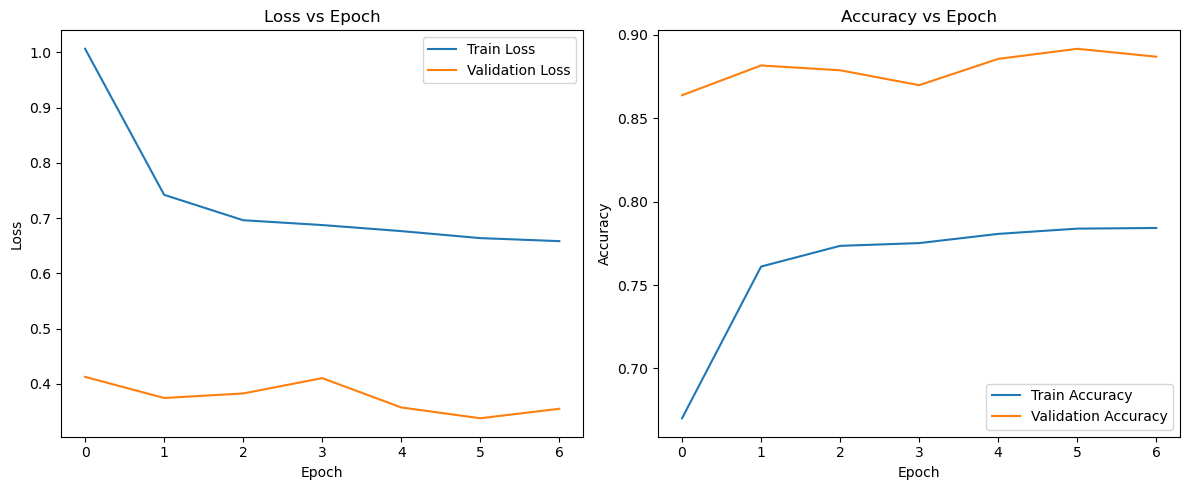


Phase 2: Fine-tuning - unfreezing some ResNet layers...
Trainable parameters: 24,466,445 / 24,691,789 (99.09%)
Epoch 1/7 | Train Loss: 0.6987 | Train Acc: 0.7756 | Val Loss: 0.3472 | Val Acc: 0.8942
Epoch 2/7 | Train Loss: 0.5899 | Train Acc: 0.8135 | Val Loss: 0.3314 | Val Acc: 0.8992
Epoch 3/7 | Train Loss: 0.5436 | Train Acc: 0.8273 | Val Loss: 0.2863 | Val Acc: 0.9112
Epoch 4/7 | Train Loss: 0.4990 | Train Acc: 0.8361 | Val Loss: 0.2885 | Val Acc: 0.9086
Epoch 5/7 | Train Loss: 0.4759 | Train Acc: 0.8482 | Val Loss: 0.2900 | Val Acc: 0.9154
Epoch 6/7 | Train Loss: 0.4682 | Train Acc: 0.8506 | Val Loss: 0.2902 | Val Acc: 0.9131
Epoch 7/7 | Train Loss: 0.4599 | Train Acc: 0.8536 | Val Loss: 0.3083 | Val Acc: 0.9089
Best Validation Accuracy: 0.9154


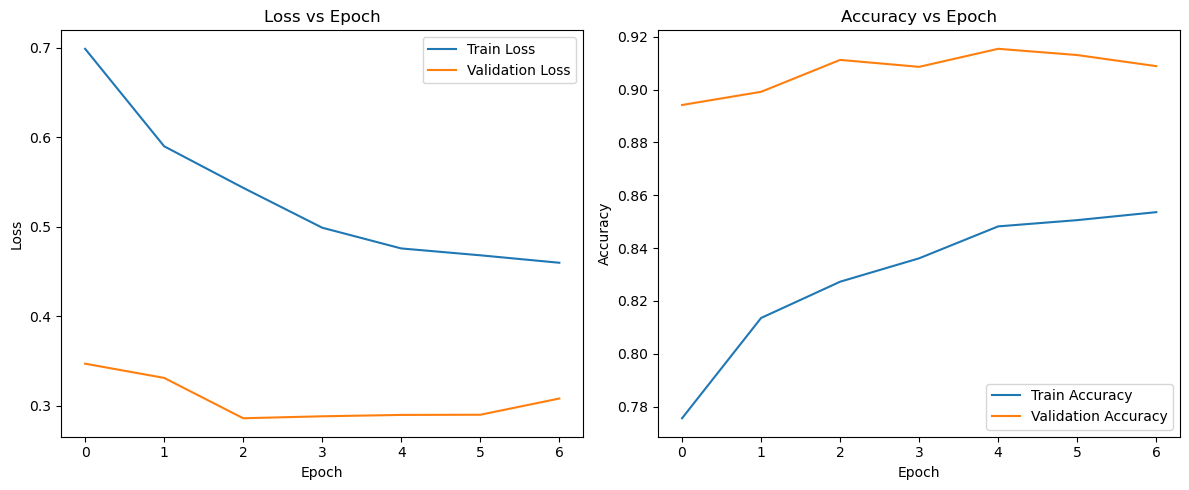


Evaluating the final model...
              precision    recall  f1-score   support

        bear     0.9719    0.9618    0.9668       288
      beaver     0.9839    0.9071    0.9439       269
         bee     0.9088    0.9300    0.9193       300
         cat     0.9595    0.7100    0.8161       300
        dove     0.9317    0.8691    0.8993       298
         elk     0.8373    0.9267    0.8797       300
    flamingo     0.9463    0.9400    0.9431       300
         fox     0.9537    0.9763    0.9648       253
        frog     0.9205    0.9267    0.9236       300
       goose     0.8944    0.9033    0.8988       300
     ladybug     0.9214    0.9767    0.9482       300
         owl     0.8725    0.8900    0.8812       300
    squirrel     0.7800    0.9100    0.8400       300

    accuracy                         0.9089      3808
   macro avg     0.9140    0.9098    0.9096      3808
weighted avg     0.9127    0.9089    0.9085      3808



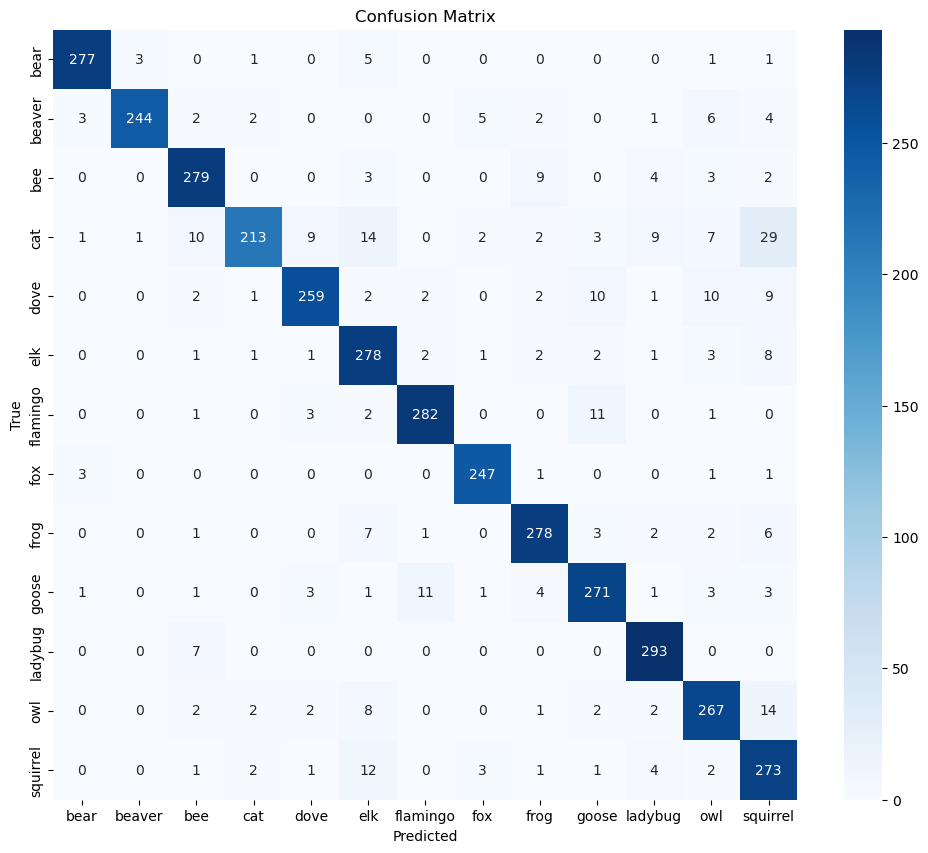

Final model saved to 'animal_classifier_final.pth'
Cleaned up temporary directory: /var/folders/5x/h31yvnc53sv2k__nnwf06_tw0000gn/T/tmpqm0p6wf3


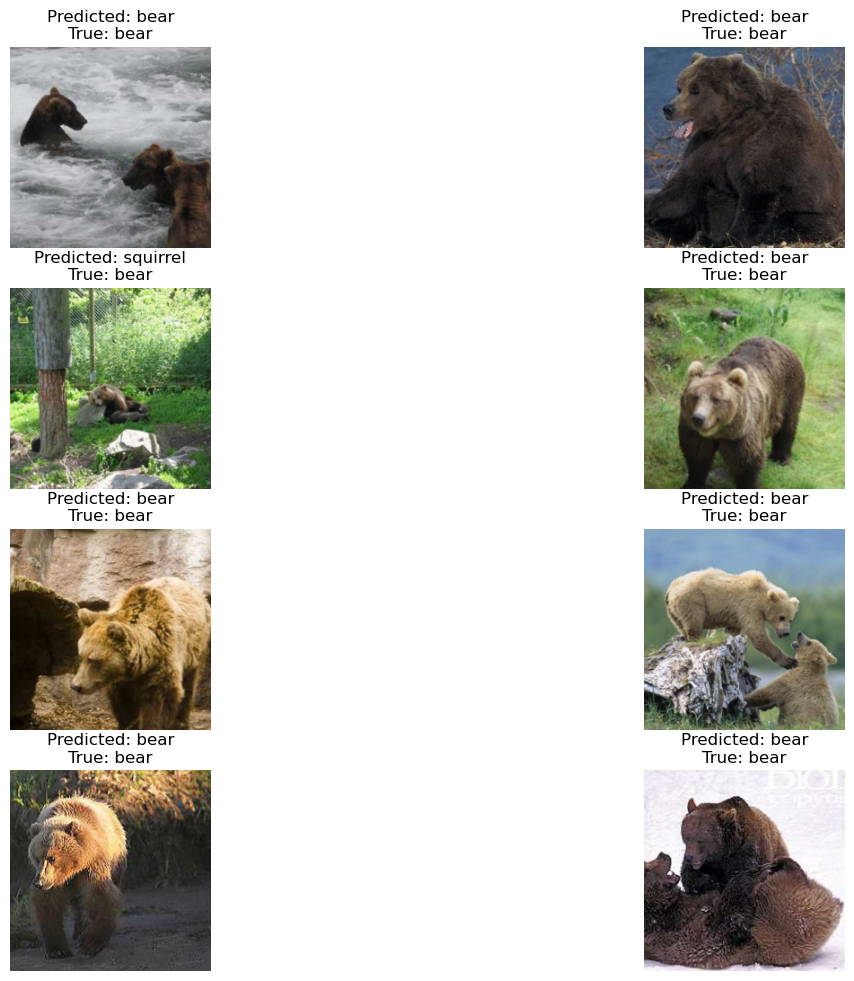

In [58]:
main()